In [1]:
import os
import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import math
from seaborn import heatmap
from matplotlib import transforms

In [2]:
def importAudio(target, reference, output=True):
    if(output):
        display(ipd.Audio(target))
        display(ipd.Audio(reference))

    tArray, tSampleRate = librosa.load(target)
    rArray, rSampleRate = librosa.load(reference)

    tSTFT = librosa.stft(tArray, n_fft=frameSize, hop_length=hopSize)
    rSTFT = librosa.stft(rArray, n_fft=frameSize, hop_length=hopSize)

    tDFT = librosa.stft(tArray, n_fft=frameSize, hop_length=10000000000)
    rDFT = librosa.stft(rArray, n_fft=frameSize, hop_length=10000000000)
    
    return ({"STFT":tSTFT,"DFT":tDFT,"sampleRate":tSampleRate},{"STFT":rSTFT,"DFT":rDFT,"sampleRate":rSampleRate})

In [3]:
def exportAudio(tAudio, mAudio, rAudio):
    print("Target")
    tInverse = librosa.istft(tAudio["STFT"],n_fft=frameSize, hop_length=hopSize)
    display(ipd.Audio(tInverse, rate=tAudio["sampleRate"]))

    print("Matched")
    mInverse = librosa.istft(mAudio["STFT"],n_fft=frameSize, hop_length=hopSize)
    display(ipd.Audio(mInverse, rate=mAudio["sampleRate"]))

    print("Reference")
    rInverse = librosa.istft(rAudio["STFT"],n_fft=frameSize, hop_length=hopSize)
    display(ipd.Audio(rInverse, rate=rAudio["sampleRate"]))

In [4]:
def plotSpectrogram(tAudio, mAudio, rAudio):

    maximum = (max(np.max(np.abs(tAudio["STFT"])**2), np.max(np.abs(rAudio["STFT"])**2)))
    
    # derives the spectrogram from the STFT
    tSpectrogram = librosa.power_to_db(np.abs(tAudio["STFT"])**2, ref=np.max)
    mSpectrogram = librosa.power_to_db(np.abs(mAudio["STFT"])**2, ref=np.max)
    rSpectrogram = librosa.power_to_db(np.abs(rAudio["STFT"])**2, ref=np.max)

    # creates plots of spectrograms
    fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10*figScale, 5*figScale))
    tImg = librosa.display.specshow(tSpectrogram,sr=tAudio["sampleRate"],hop_length=hopSize,x_axis="time",y_axis="mel",cmap="magma",ax=ax[0])
    mImg = librosa.display.specshow(mSpectrogram,sr=mAudio["sampleRate"],hop_length=hopSize,x_axis="time",y_axis="mel",cmap="magma",ax=ax[1])
    rImg = librosa.display.specshow(rSpectrogram,sr=rAudio["sampleRate"],hop_length=hopSize,x_axis="time",y_axis="mel",cmap="magma",ax=ax[2])

    # adjusts appearance
    ax[0].set(title='Target')
    ax[1].set(title='Matched')
    ax[2].set(title='Reference')
    for ax_i in ax:
        ax_i.label_outer()
    fig.colorbar(mImg, ax=[ax[0], ax[1], ax[2]],format='%+2.0f dB')


<h3>Matching based on gain average of frequency bands</h3>

In [115]:
def plotCurve(tCurve,tCurveSmooth,rCurve,rCurveSmooth,mCurve):
    plt.figure(figsize=(10*figScale,5*figScale))

    plt.plot(20*np.log10(tCurve), alpha=0.2, color='blue', label="Target")
    plt.plot(20*np.log10(tCurveSmooth), color='blue', label="Convolved Target")

    plt.plot(20*np.log10(rCurve), alpha=0.2, color='red', label="Reference")
    plt.plot(20*np.log10(rCurveSmooth), color='red', label="Convolved Reference")

    plt.plot(20*np.log10(mCurve), color='green', label="Matched")

    #plt.yscale("log")
    plt.xlabel("Frequency Bin")
    plt.ylabel("Gain (dB)")
    plt.legend()

In [69]:
def convolve(curve, smoothing):
    curve = np.ravel(curve)
    kernel = np.ones(smoothing) / smoothing
    curve = np.convolve(curve, kernel, mode='same')
    curve = curve.reshape(len(curve),1)
    return curve

def EQMatching(tAudio, rAudio, smoothing=1, plot=True):
    tCurve = np.abs(tAudio["DFT"])
    tCurveSmooth = convolve(tCurve, smoothing)

    rCurve = np.abs(rAudio["DFT"])
    rCurveSmooth = convolve(rCurve, smoothing)

    scaler = rCurveSmooth / tCurveSmooth
    
    mSTFT = tAudio["STFT"] * scaler
    mDFT = tAudio["DFT"] * scaler
    mAudio = {"STFT":mSTFT,"DFT":mDFT,"sampleRate":tAudio["sampleRate"]}

    if(plot):
        mCurve = np.abs(mDFT)
        plotCurve(tCurve,tCurveSmooth,rCurve,rCurveSmooth,mCurve)
    
    return mAudio

In [164]:
def dynamicMatching(tAudio,rAudio,dynamicBins):
    freqBinNum = 10

    freqBin = [np.abs(tAudio["STFT"][freqBinNum,:]), np.abs(rAudio["STFT"][freqBinNum,:])]
    dynamicRange = (min(min(freqBin[0]),min(freqBin[1])), max(max(freqBin[0]),max(freqBin[1])))
    dynamicResponse = [np.histogram(freqBin[0],bins=dynamicBins,range=dynamicRange)[0], np.histogram(freqBin[1],bins=dynamicBins,range=dynamicRange)[0]]
    dynamicFreqRange = (min(min(dynamicResponse[0]),min(dynamicResponse[1])),max(max(dynamicResponse[0]),max(dynamicResponse[1])))

    fig, ax = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='col', figsize=(10*figScale, 5*figScale), gridspec_kw={'width_ratios': [8, 1]})
    
    for i in range(2):
        ax[i,0].plot(freqBin[i])
        
        tr = transforms.Affine2D().rotate_deg(90)
        reshape = np.flip(dynamicResponse[i].reshape(dynamicResponse[i].shape[0], 1))
        sns = heatmap(reshape, ax=ax[i,1], vmin=dynamicFreqRange[0], vmax=dynamicFreqRange[1], cmap="magma")
        ax[i,1].set_xticks([])
        ax[i,1].set_yticks([])
        ax[i,0].set_ylabel("Level")
        ax[i,0].set_xlabel("Frame")
        fig.tight_layout(rect=[0, 0, .9, 1])
        
    for ax_i in ax:
        ax_i[0].label_outer()


<h1>Execution</h1>

In [105]:
frameSize=2048
hopSize=512

figScale = 1

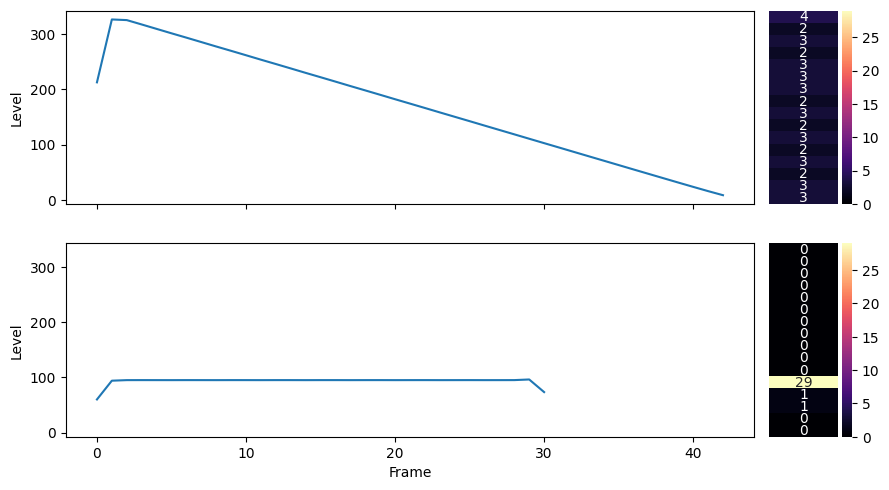

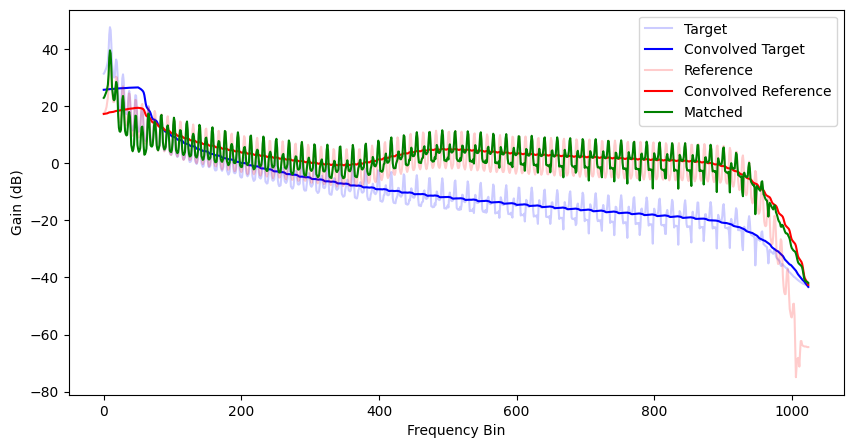

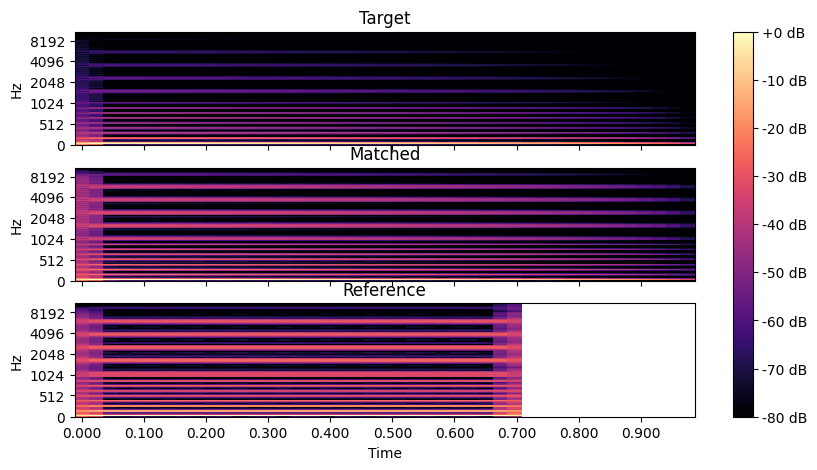

In [165]:
tAudio, rAudio = importAudio(target="tone1.wav",reference="tone2loud.wav", output=False)

dynamicMatching(tAudio,rAudio,dynamicBins=16)
mAudio = EQMatching(tAudio,rAudio,smoothing=100, plot=True)

plotSpectrogram(tAudio, mAudio, rAudio)

In [12]:
exportAudio(tAudio, mAudio, rAudio)

Target


Matched


Reference
